In [16]:
import matplotlib.pyplot as plt
import os
import cv2
from frame_helpers import colorize, convert_to_bgra_if_required
from pyk4a import PyK4APlayback
from torchvision import transforms

In [3]:
# print mkv recording length
def info(playback: PyK4APlayback):
    print(f"Record length: {playback.length / 1000000: 0.2f} sec")

In [ ]:
# Load an MKV file
if os.path.exists("C:/Users/tiani/SeniorDesign/ecj1204_2023-11-7.mkv"):
    mkv_file = "C:/Users/tiani/SeniorDesign/ecj1204_2023-11-7.mkv"
else:
    print("That path doesn't exist bruh lol")
    exit()

playback = PyK4APlayback(mkv_file)
playback.open()
playback.seek(5000000) # in microseconds, aka 5 seconds
info(playback) # prints the recording length

# print(type(playback))

while True:
    try:
        capture = playback.get_next_capture()
      
        plt.figure(figsize=(10,4))

        if capture.color is None:
            print("No capture color")
        if capture.color is not None:
            # shows the original RGB photo, not cropped 
            # plt.imshow(cv2.cvtColor(convert_to_bgra_if_required(0, capture.color), cv2.COLOR_BGR2RGB))
            # plt.show()

            plt.subplot(1,2,1)
            img_color = cv2.resize(cv2.cvtColor(convert_to_bgra_if_required(0, capture.color), cv2.COLOR_BGR2RGB)[80:720, 446: 926, 0:3], (640, 480))
            plt.imshow(img_color)
            plt.title ("Color Image")

        if capture.depth is None:
            print("No capture depth")
        if capture.depth is not None:
            # shows the original depth photo, not cropped 
            # plt.imshow(center_crop(cv2.cvtColor(colorize(capture.depth, (None, 5000)), cv2.COLOR_BGR2RGB), (480,640)))
            # plt.show()

            plt.subplot(1,2,2)
            # transformed frame aligns the depth frame with the color frame. It is able do this through the capture
            img_depth = cv2.resize(capture.transformed_depth[240:720, 286: 926], (640, 480))
            plt.imshow(img_depth)
            plt.title("Depth Image")

        plt.suptitle("Capture at {} s".format(float(capture.color_timestamp_usec / 1000000)))
        plt.show()

        # does not wait for a key press to get the next capture. 
        key = cv2.waitKey(0)
        if key != -1:
            break
    except EOFError:
        break  

# Release OpenCV windows
cv2.destroyAllWindows()
playback.close()


In [54]:
import h5py


# Load an MKV file
if os.path.exists("C:/Users/vliew/Documents/UTAustin/Fall2023/SeniorDesign/output.mkv"):
    mkv_file = "C:/Users/vliew/Documents/UTAustin/Fall2023/SeniorDesign/output.mkv"
else:
    print("That path doesn't exist bruh lol")
    exit()

playback = PyK4APlayback(mkv_file)
playback.open()
playback.seek(5000000) # in microseconds, aka 5 seconds
info(playback) # prints the recording length

# print(type(playback))
# Create a new HDF5 file
file = h5py.File('output_1.h5', 'w')

# Create datasets for RGB images and depth maps
rgb_images = file.create_dataset('images', (0, 640, 480, 3), maxshape=(None, 640,480, 3))
depth_images = file.create_dataset('depths', (0, 640, 480), maxshape=(None, 640, 480))

i = 0
while True:
    try:
        capture = playback.get_next_capture()

        if capture.color is not None:
            img_color = cv2.resize(cv2.cvtColor(convert_to_bgra_if_required(0, capture.color), cv2.COLOR_BGR2RGB)[80:720, 446: 926, 0:3], (480, 640))

            # Append the RGB image to the dataset
            rgb_images.resize(i + 1, axis=0)
            rgb_images[i] = img_color

        if capture.depth is not None:
            img_depth = cv2.resize(capture.transformed_depth[80:720, 446: 926], (480, 640))

            # Append the depth map to the dataset
            depth_images.resize(i + 1, axis=0)
            depth_images[i] = img_depth

        i += 1

        # key = cv2.waitKey(0)
        # if key != -1:
        #     break
    except EOFError:
        break

# Close the HDF5 file
file.close()

Record length:  10.20 sec


In [10]:
file.close()

In [12]:
mat_file = h5py.File('output.h5', 'r')

In [13]:
rgb_images = mat_file['images'][:]
depth_images = mat_file['depths'][:]

In [14]:
depth_images[0].shape

(640, 480)

In [17]:
transform = transforms.ToTensor()

In [19]:
transform(depth_images[0]).shape

torch.Size([1, 640, 480])

In [22]:
import torch
import random
from torch.utils.data import DataLoader, Dataset

In [23]:
class CustomDataset(Dataset):
    """
    Customized DataSet for grabbing images. DataLoader wraps around this Dataset class to generate batches.

    Args:
        Dataset (torch.utils.Dataset): torch.utils.data.Dataset superclass.
    """
    def __init__(self, data, labels):
        """
        Initialize a CustomDataset using input tensors and label tensors.

        Args:
            data (list of list of torch.Tensor): Input tensors.
            labels (list of torch.Tensor): Label tensors.
        """
        self.data = data
        self.labels = labels
        self.transform = transforms.RandomHorizontalFlip()

    def __len__(self):
        """
        Returns the length of the entire Dataset.

        Returns:
            integer: Length of CustomDataset. 
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns a tuple of the input tensors and ground truth tensors based on index.

        Args:
            idx (integer): The accessed index.

        Returns:
            tuple: A tuple of the input and ground truth tensors.
                - torch.Tensor: Input tensor.
                - torch.Tensor: Ground truth tensor. 
        """
        
        img = self.data[idx]
        truth = self.labels[idx]
        
        if self.transform:
            # to_pil = transforms.ToPILImage()
            # to_tensor = transforms.ToTensor()
            
            # img = to_pil(img)
            # img = self.transform(img)
            # img = to_tensor(img)
            p = random.random()
            if p >.5:
                img = torch.flip(img, dims=[2])
                truth = torch.flip(truth, dims=[2])
            
        return img, truth

In [52]:
def create_data_set(file_name):
    mat_file = h5py.File(f'{file_name}', 'r')
    rgb_images = mat_file['images'][:]
    depth_images = mat_file['depths'][:]

    transform = transforms.ToTensor()
    X_train = rgb_images
    y_train = depth_images

    X_train_tensors = []
    for x in X_train:
        x = transform(x)
        X_train_tensors.append(x)
    y_train_tensors = []
    train_max = 0
    for y in y_train:
        y = transform(y)
        train_max = torch.max(y) if torch.max(y) > train_max else train_max
        y_train_tensors.append(y / train_max)
    mat_file.close()

    return X_train_tensors, y_train_tensors

In [29]:
def create_data_loader(x, y):
    dataset = CustomDataset(x, y)
    loader = DataLoader(dataset, batch_size=4, shuffle=True)
    return loader

In [55]:
X_train, y_train = create_data_set('output_1.h5')
data_loader = create_data_loader(X_train, y_train)

In [49]:
import numpy as np

C:\Users\vliew\AppData\Local\Temp\ipykernel_18340\991811245.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  i_np = i.astype(np.int)


(640, 480, 3)


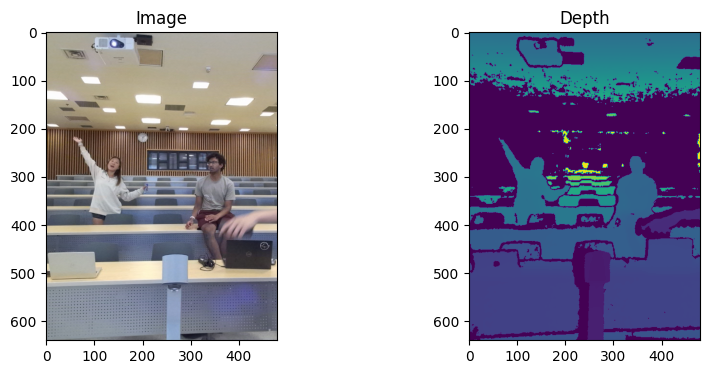

(640, 480, 3)


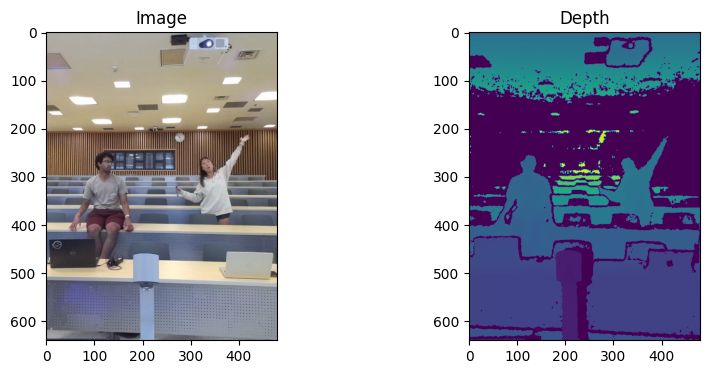

In [56]:
for idx, (image, depth) in enumerate(data_loader):
    # print(image[0])
    i = image[0].transpose(1, 0)
    i = i.transpose(1, 2)
    i = i.numpy()
    i_np = i.astype(np.int)
    print(i.shape)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(i_np)
    plt.title("Image")
    plt.subplot(1,2,2)
    plt.imshow(depth[0][0])
    plt.title("Depth")
    plt.show()
    if (idx == 1):
        break